# Segmenting and Clustering Neighborhoods in Toronto Project

### Please Read all lines of the Code for Reviewing

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    cer

In [2]:
from bs4 import BeautifulSoup # scraping library

# Question 1

# Step 1: Extract data of Toronto neighborhoods from Wikipedia

In [7]:
# Extract data of Toronto neighborhoods from Wikipedia html
html = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

# determine the index of your table
neightborhood_df = pd.read_html(html, header = 0)[0]

# Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
neightborhood_df = neightborhood_df[neightborhood_df.Borough != 'Not assigned']

# More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
neightborhood_df = neightborhood_df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()

# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.
for index, row in neightborhood_df.iterrows():
    if row['Neighbourhood'] == 'Not assigned':
        row['Neighbourhood'] = row['Borough']

# Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.
neightborhood_df.head(10)

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [8]:
print('The DataFrame shape is', neightborhood_df.shape)

The DataFrame shape is (103, 3)


# Question 2

# Step 2: Getting Latitude & Longitude From Geospatial

In [9]:
import io

In [10]:
# in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.
url="http://cocl.us/Geospatial_data"
source=requests.get(url).content
coordinates_df=pd.read_csv(io.StringIO(source.decode('utf-8')))

# rename the first column to allow merging dataframes on Postcode
coordinates_df.columns = ['Postcode', 'Latitude', 'Longitude']
coordinates_df.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [12]:
neightborhood_coordinates_df = neightborhood_df.join(coordinates_df.set_index('Postcode'), on='Postcode')
neightborhood_coordinates_df.head(16)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [13]:
map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in neightborhood_coordinates_df.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-2], location[-1]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=500,
        popup=label,
        location=[location[-2], location[-1]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

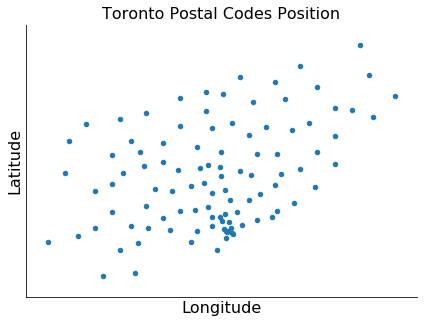

In [17]:
import matplotlib.pyplot as plt

X = neightborhood_coordinates_df[['Longitude', 'Latitude']]

scatter_plot = X.plot.scatter(x='Longitude', 
               y='Latitude',  
               fontsize = 16,
               figsize=(7, 5))

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
scatter_plot.set_title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

In [18]:
from geopy.distance import great_circle

#function to get the closest postcode pair and the distance using latitude and longitude
def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]

In [19]:

coordinates = neightborhood_coordinates_df[['Latitude', 'Longitude']]

distance, closest_point_index = closest_postcode(coordinates[:1], coordinates[~coordinates.index.isin([0])])
close_points = X[:1].append(X[closest_point_index+1:closest_point_index+2])
close_points

,Longitude,Latitude
0,-79.194353,43.806686
16,-79.205636,43.836125


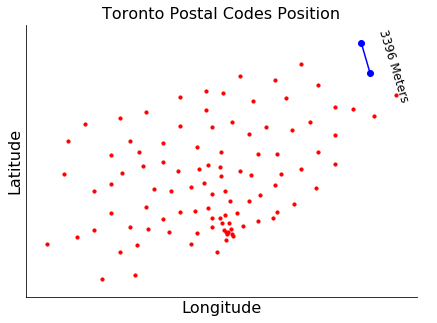

In [20]:
fig = plt.figure(figsize=(7,5))
scatter_plot = fig.add_subplot(111)
scatter_plot.scatter(X['Longitude'],X['Latitude'], s=10, c='r', marker="o")
scatter_plot.plot(close_points['Longitude'], close_points['Latitude'], c='b', marker="o")

# plt.legend(loc='upper left');
scatter_plot.annotate('{} Meters'.format(distance),
            xy=(.859, .912), xycoords='figure fraction',
            ha='left', va='top', rotation=-73,
            fontsize=12)

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)

plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

In [21]:
from math import isnan

for lat, lng, idx in zip(neightborhood_coordinates_df['Latitude'], neightborhood_coordinates_df['Longitude'], neightborhood_coordinates_df.index):
    distance, closest_point_index = closest_postcode([lat,lng], coordinates[~coordinates.index.isin([idx])])
    neightborhood_coordinates_df.at[idx,'Distance'] = np.int64(distance//2) #use the half of the disstance to avoid overlapping
    
neightborhood_coordinates_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Distance
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1698.0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1625.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1205.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,913.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,913.0


In [22]:
map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in neightborhood_coordinates_df.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-3], location[-2]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=location[-1],
        popup=label,
        location=[location[-3], location[-2]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

# Question 3

# Step 3: Obtain the Venues in the Perimeter of Each Postal Code

In [58]:
CLIENT_ID = 'Insert Your Foursquare ID' # your Foursquare ID
CLIENT_SECRET = 'Insert Your Foursquare Secret' # your Foursquare Secret
VERSION = '20181102'

In [24]:
#function to format url
def format_url(lat, lng, radius=500, limit=100):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
        lat, lng, VERSION, radius, limit)

In [25]:
first_postcode = neightborhood_coordinates_df.iloc[2, :]
url = format_url(first_postcode['Latitude'], first_postcode['Longitude'], first_postcode['Distance'])

In [26]:
#function to get batch of venues as a dataframe
def get_venues(url):
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    return json_normalize(venues)

In [27]:
venues_df = get_venues(url)

venues_df.head()

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4bc366dab492d13a51b2a860-0,"[{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...",4bc366dab492d13a51b2a860,4449 Kingston Road,CA,Scarborough,Canada,at Lawrence and Morningside,579,[4449 Kingston Road (at Lawrence and Morningsi...,"[{'label': 'display', 'lat': 43.76875171771289...",43.768752,-79.187982,M1E 2N7,ON,Chick-N-Joy,0,[]
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ba164fdf964a52039b337e3-1,"[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",4ba164fdf964a52039b337e3,4525 Kingston Rd,CA,West Hill,Canada,Morningside Crossing,933,"[4525 Kingston Rd (Morningside Crossing), West...","[{'label': 'display', 'lat': 43.77134173380578...",43.771342,-79.184341,NaN,ON,Bulk Barn,0,[]
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b3a9504f964a520646a25e3-2,"[{'id': '4bf58dd8d48988d186941735', 'name': 'L...",4b3a9504f964a520646a25e3,4525 Kingston Rd.,CA,Toronto,Canada,at Lawrence Ave. E,944,"[4525 Kingston Rd. (at Lawrence Ave. E), Toron...","[{'label': 'display', 'lat': 43.77146181777272...",43.771462,-79.184384,M1E 2P1,ON,LCBO,0,[]
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4c9fdb04542b224bca4201a0-3,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",4c9fdb04542b224bca4201a0,4218 Lawrence Avenue East,CA,Scarborough,Canada,NaN,701,"[4218 Lawrence Avenue East, Scarborough ON M1E...","[{'label': 'display', 'lat': 43.76904597684398...",43.769046,-79.184386,M1E 4X9,ON,Little Caesars Pizza,0,[]
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-510bd6f1e4b0256d6cc14409-4,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",510bd6f1e4b0256d6cc14409,4551 Kingston Rd.,CA,Toronto,Canada,Lawrence,1020,"[4551 Kingston Rd. (Lawrence), Toronto ON 4551...","[{'label': 'display', 'lat': 43.77231854994461...",43.772319,-79.184900,4551 Kingsto,ON,Sunset Grill,0,[]


In [28]:
#function to clean the venues dataframe
def clean_df(df):
    relevant_columns = ['venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.name']
    clean_df = df.loc[:,relevant_columns]

    #rename columns
    clean_df.columns = ['Category', 'Lat', 'Lng', 'Name']
    return clean_df 

venues_df = clean_df(venues_df)
venues_df.head()

,Category,Lat,Lng,Name
0,"[{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...",43.768752,-79.187982,Chick-N-Joy
1,"[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",43.771342,-79.184341,Bulk Barn
2,"[{'id': '4bf58dd8d48988d186941735', 'name': 'L...",43.771462,-79.184384,LCBO
3,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",43.769046,-79.184386,Little Caesars Pizza
4,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",43.772319,-79.184900,Sunset Grill


In [29]:
venues_df.loc[0, 'Category']

[{'id': '4d4ae6fc7a7b7dea34424761',
  'name': 'Fried Chicken Joint',
  'pluralName': 'Fried Chicken Joints',
  'shortName': 'Fried Chicken',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/friedchicken_',
   'suffix': '.png'},
  'primary': True}]

In [30]:
#function that extract the category name
def get_category_name(row):
    category_json = row['Category']
    try:
        return category_json[0]['name']
    except:        
        return None

venues_df['Category'] = venues_df.apply(get_category_name, axis=1)

venues_df

,Category,Lat,Lng,Name
0,Fried Chicken Joint,43.768752,-79.187982,Chick-N-Joy
1,Food & Drink Shop,43.771342,-79.184341,Bulk Barn
2,Liquor Store,43.771462,-79.184384,LCBO
3,Pizza Place,43.769046,-79.184386,Little Caesars Pizza
4,Breakfast Spot,43.772319,-79.184900,Sunset Grill
5,Smoothie Shop,43.770668,-79.184150,Booster Juice
6,Pizza Place,43.767697,-79.189914,Swiss Chalet Rotisserie & Grill
7,Coffee Shop,43.770370,-79.186490,Starbucks
8,Beer Store,43.769793,-79.187505,The Beer Store
9,Pharmacy,43.770282,-79.185012,Shoppers Drug Mart


In [31]:
#function to construct the dataframe with all the venues (max 100 venues per postal code)
def get_all_venues(postcodes, lat, lng, radius):
    venues_list=[]
    for postcode, lat, lng, radius in zip(postcodes, lat, lng, radius):
        url= format_url(lat, lng, radius)
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            postcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name'])
            for v in results])
    all_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    all_venues.columns = ['Postcode', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category'
                  ]
    
    return all_venues

In [32]:
all_venues = get_all_venues(neightborhood_coordinates_df['Postcode'], neightborhood_coordinates_df['Latitude'], neightborhood_coordinates_df['Longitude'], neightborhood_coordinates_df['Distance'])

print('The total number of venues returned is ', all_venues.shape[0])

all_venues.head(10)

The total number of venues returned is  3340


,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,African Rainforest Pavilion,43.817725,-79.183433,Zoo Exhibit
1,M1B,43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa
2,M1B,43.806686,-79.194353,Canadiana exhibit,43.817962,-79.193374,Zoo Exhibit
3,M1B,43.806686,-79.194353,penguin exhibit,43.819435,-79.185959,Zoo Exhibit
4,M1B,43.806686,-79.194353,Gorilla Exhibit,43.819080,-79.184235,Zoo Exhibit
5,M1B,43.806686,-79.194353,Orangutan Exhibit,43.818413,-79.182548,Zoo Exhibit
6,M1B,43.806686,-79.194353,Lion Exhibit,43.819228,-79.186977,Zoo Exhibit
7,M1B,43.806686,-79.194353,Giraffe Exhibit,43.819851,-79.186692,Zoo Exhibit
8,M1B,43.806686,-79.194353,LCBO,43.796671,-79.204586,Liquor Store
9,M1B,43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant


In [33]:
print('Total Toronto postcodes:', neightborhood_coordinates_df['Postcode'].shape[0])
print('Total Toronto postcodes with venues:', all_venues['Postcode'].unique().shape[0])

Total Toronto postcodes: 103
Total Toronto postcodes with venues: 102


In [34]:
postcodes_diff = np.setdiff1d(neightborhood_coordinates_df['Postcode'].values,all_venues['Postcode'].unique())
neightborhood_coordinates_df[neightborhood_coordinates_df['Postcode']==postcodes_diff[0]]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Distance
56,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,111.0


# Step 4: Analysis of Venues Data

In [35]:
venues_in_postcode = all_venues.groupby('Postcode').count()
venues_in_postcode = pd.DataFrame(list(zip(venues_in_postcode.index, venues_in_postcode['Venue'])), 
                                  columns=['Postcode', 'No. of Venues']).set_index('Postcode').join(neightborhood_coordinates_df[['Postcode','Distance']].set_index('Postcode'), on='Postcode').reset_index()
venues_in_postcode['Distance'] = np.int64(venues_in_postcode['Distance'])
venues_in_postcode.loc[len(venues_in_postcode.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as # of venues

venues_in_postcode.head(10)

,Postcode,No. of Venues,Distance
0,M1B,35,1698
1,M1C,7,1625
2,M1E,26,1205
3,M1G,5,913
4,M1H,22,913
5,M1J,25,1301
6,M1K,27,1112
7,M1L,32,1052
8,M1M,18,1112
9,M1N,16,1297


In [36]:
venues_in_postcode[['No. of Venues']].describe()

,No. of Venues
count,103.000000
mean,32.427184
std,25.646772
min,0.000000
25%,13.000000
50%,26.000000
75%,43.500000
max,100.000000


In [38]:
density_venues_in_postcode = all_venues.groupby('Postcode').count()

density_venues_in_postcode = pd.DataFrame(list(zip(density_venues_in_postcode.index, density_venues_in_postcode['Venue'])), 
                                  columns=['Postcode', 'Density']).set_index('Postcode').join(neightborhood_coordinates_df[['Postcode','Distance']].set_index('Postcode'), on='Postcode').reset_index()
density_venues_in_postcode['Density'] = np.int64(density_venues_in_postcode['Density']/(density_venues_in_postcode['Distance']/1000)) #distance in km
density_venues_in_postcode.loc[len(venues_in_postcode.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as density

density_venues_in_postcode.head(10)

,Postcode,Density,Distance
0,M1B,20,1698.0
1,M1C,4,1625.0
2,M1E,21,1205.0
3,M1G,5,913.0
4,M1H,24,913.0
5,M1J,19,1301.0
6,M1K,24,1112.0
7,M1L,30,1052.0
8,M1M,16,1112.0
9,M1N,12,1297.0


In [39]:
density_venues_in_postcode[['Density']].describe()

,Density
count,103.000000
mean,46.213592
std,48.215539
min,0.000000
25%,15.000000
50%,29.000000
75%,60.500000
max,269.000000


# Step 5: Clustering of Postcodes

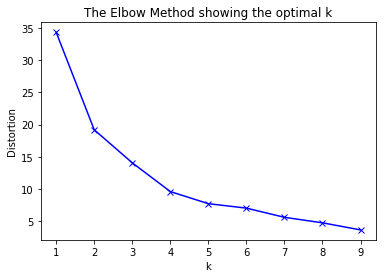

In [40]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
    k_means.fit(density_venues_in_postcode['Density'].values.reshape(-1, 1))
    distortions.append(sum(np.min(cdist(density_venues_in_postcode['Density'].values.reshape(-1, 1),
                                        k_means.cluster_centers_, 'euclidean'), axis=1)) / density_venues_in_postcode['Density'].shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [41]:
num_clusters = 5 # the optimal value of the number of cluster was defined as 5

k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 12)
k_means.fit(density_venues_in_postcode['Density'].values.reshape(-1, 1))
labels = k_means.labels_

print(labels)

[1 1 1 1 1 1 1 3 1 1 3 3 3 3 3 3 1 1 3 1 1 3 0 3 1 3 3 3 3 3 1 1 1 1 1 1 1
 0 0 3 3 4 3 4 1 1 3 0 1 0 1 0 2 0 2 0 0 4 2 0 4 3 1 1 3 0 2 3 0 0 3 3 1 1
 3 3 4 0 1 1 3 0 0 0 1 3 3 3 3 3 1 3 1 1 1 1 1 1 1 1 1 1 1]


In [42]:
density_venues_in_postcode['Cluster'] = k_means.labels_
density_venues_in_postcode.head()

,Postcode,Density,Distance,Cluster
0,M1B,20,1698.0,1
1,M1C,4,1625.0,1
2,M1E,21,1205.0,1
3,M1G,5,913.0,1
4,M1H,24,913.0,1


# Step 6: Examining of Clusters

In [43]:
centroids = np.int64(round(density_venues_in_postcode.groupby('Cluster').mean()['Density']))
frecuency = density_venues_in_postcode.groupby('Cluster').count()['Postcode']

cluster_info = pd.DataFrame([np.arange(0,5), centroids, frecuency], index=['Cluster', 'Centroid','Postcodes']).T
cluster_info.sort_values('Centroid', inplace=True)
cluster_info.reset_index(drop=True, inplace=True)

cluster_info

,Cluster,Centroid,Postcodes
0,1,13,44
1,3,38,33
2,0,84,17
3,4,130,5
4,2,216,4


In [53]:
# 'Low Venues Density': Centroid equal to 13
# 'Medium-Low Venues Density' with a centroid equal to 38
# 'Medium-High Venues Density' with a centroid equal to 84
# 'High Venues Density' with a centr0id equal to 130
# 'Very High Venues Density' with a centroid equal to 216
raw_data = {'cluster': ['Low Venues Density','Medium-Low Venues Density','Medium-High Venues Density','High Venues Density','Very High Venues Density'],
        'Postcodes': [44, 33, 17, 5, 4]}
df = pd.DataFrame(raw_data, columns = ['cluster', 'Postcodes'])
df

,cluster,Postcodes
0,Low Venues Density,44
1,Medium-Low Venues Density,33
2,Medium-High Venues Density,17
3,High Venues Density,5
4,Very High Venues Density,4


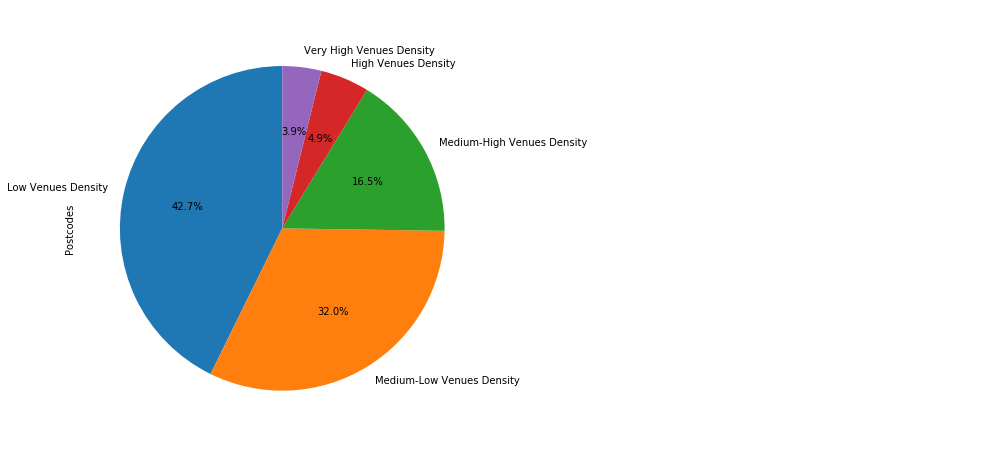

In [56]:
plt.figure(figsize=(16,8))
# plot chart
ax1 = plt.subplot(121, aspect='equal')
df['Postcodes'].plot(kind='pie', y = 'Clustter', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=df['cluster'], legend = False, fontsize=10)

# plot table
ax2 = plt.subplot(122)
plt.axis('off')
plt.show()

In [57]:
neightborhood_coordinates_df = pd.concat([neightborhood_coordinates_df[:56],neightborhood_coordinates_df[57:],neightborhood_coordinates_df[56:57]]) #move M5E to the last row
neightborhood_coordinates_df['Cluster'] = k_means.labels_

colors = ['red','green','blue','cyan','magenta']
clusters_values = cluster_info['Cluster']

map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in neightborhood_coordinates_df.itertuples(): #iterate each row of the dataframe
    cluster_index = clusters_values.index[clusters_values==location[-1]][0]
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}; {}'.format(location[1], location[2], location[3], clusters[cluster_index])
    label = folium.Popup(label, parse_html=True)    
    folium.Circle(
        radius=location[-2],
        popup=label,
        location=[location[-4], location[-3]],
        color=None,
        fill=True,
        fill_opacity=0.4,
        fill_color=colors[cluster_index]
    ).add_to(map) 

map